In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
k_data_path = os.path.join(os.pardir, 'Data', 'K-Data.csv')
k_data = pd.read_csv(k_data_path)

v1_data = k_data[k_data.region == 'V1']
    
print(v1_data.m.unique())
m = v1_data.m.unique()[2]
v1_data = v1_data[v1_data.m == m]
print(len(v1_data))

v1_data.head()

/var/folders/n5/hb4kjbnx7ps8vgjsds15rzvh0000gn/T/ipykernel_2471/3389945841.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  k_data = pd.read_csv(k_data_path)


['Ntsr1Cre_2020_0001' 'PVCre_2019_0002' 'PVCre_2019_0009']
345600


,m,s,e,u,grat_orientation,grat_contrast,grat_spat_freq,grat_phase,response,smoothed_response,region,unit_type,response_type,invariance,fit_quality,c_inv_ts
287681,PVCre_2019_0009,2,5,2,0,0.0,0.010000,0,0.000000,0.000000,V1,excit,rising,invariant,good,2021-05-21 14:50:05
287682,PVCre_2019_0009,2,5,2,0,0.0,0.010000,90,0.002663,0.002397,V1,excit,rising,invariant,good,2021-05-21 14:50:05
287683,PVCre_2019_0009,2,5,2,0,0.0,0.010000,180,0.000000,0.000000,V1,excit,rising,invariant,good,2021-05-21 14:50:05
287684,PVCre_2019_0009,2,5,2,0,0.0,0.010000,270,0.002181,0.002181,V1,excit,rising,invariant,good,2021-05-21 14:50:05
287685,PVCre_2019_0009,2,5,2,0,0.0,0.024022,0,0.002398,0.002398,V1,excit,rising,invariant,good,2021-05-21 14:50:05


Data type warning because some unit_type are NaN

In [41]:
orientations = v1_data.grat_orientation.unique()
contrasts = v1_data.grat_contrast.unique()
spatial_frequencies = v1_data.grat_spat_freq.unique()
phases = v1_data.grat_phase.unique()
units = sorted(v1_data.u.unique())


The following code defines a function to construct a matrix of responses with varying orientation and contrast. It requires a unit, u, to be specified. A given grating spatial frequency or phase can be specified, otherwise all values will be averaged over.

In [65]:
def oc_matrix(u, freq=None, phase=None):
    u_data = v1_data[v1_data.u == u]
    
    if freq is not None:
        u_data = u_data[u_data.grat_spat_freq == freq]
    if phase is not None:
        u_data = u_data[u_data.grat_phase == phase]
    
    M = np.zeros((len(orientations), len(contrasts)))
    Sd = np.zeros_like(M)
    
    for i, th in enumerate(orientations):
        ori_data = u_data[u_data.grat_orientation == th]
        for j, c in enumerate(contrasts):
            con_data = ori_data[ori_data.grat_contrast == c]
            
            M[i,j] = np.mean(con_data.response)
            Sd[i,j] = np.std(con_data.response)
            
    return M, Sd

The following function plots a heatmap of the firing rates in the given matrix.

In [5]:
def oc_heatmap(M, vmax=None):
    fig, ax = plt.subplots()
    im = ax.imshow(M, cmap='hot', interpolation='nearest', vmin=0, vmax=vmax)

    ax.set_yticks(np.arange(len(orientations)), labels = orientations)
    ax.set_xticks(np.arange(len(contrasts)), labels = contrasts)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Firing Rate (Hz)', rotation=-90, va="bottom")

    ax.set_xlabel('Contrast')
    ax.set_ylabel('Orientation (deg)')


    plt.show()

Plotting a heatmap without specifying a grating spatial frequency. The unit shows very little orientation selectivity.

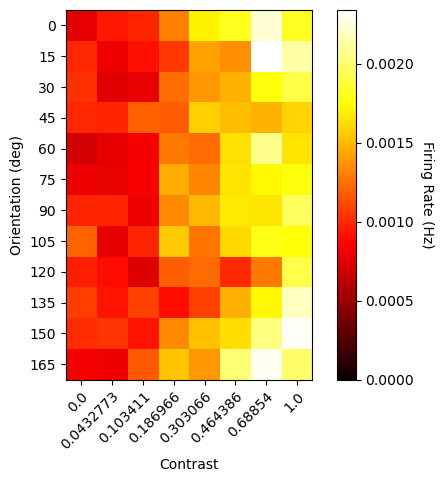

In [6]:
M, Sd = oc_matrix(2)
oc_heatmap(M)

Trying a couple of specified spatial frequencies, the unit appears to show a PO of 165° for one spatial frequency but 90° for another. This behaviour suggests that data should be conditional for spatial frequencies.

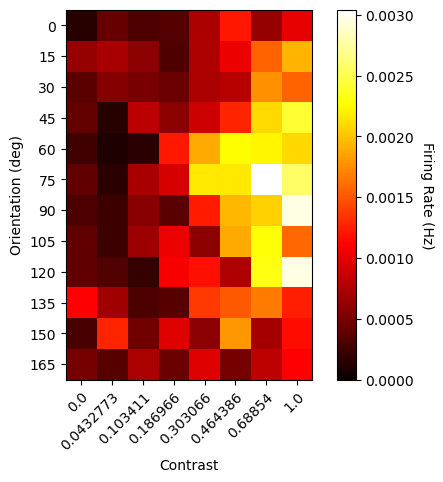

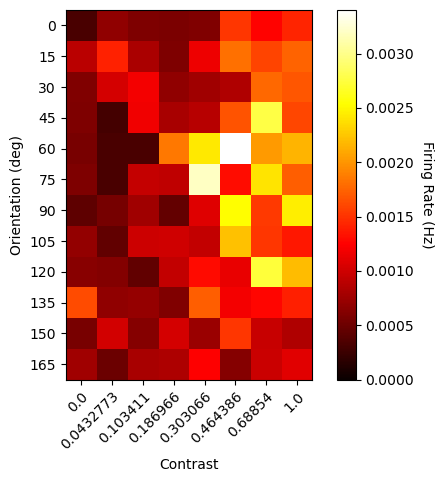

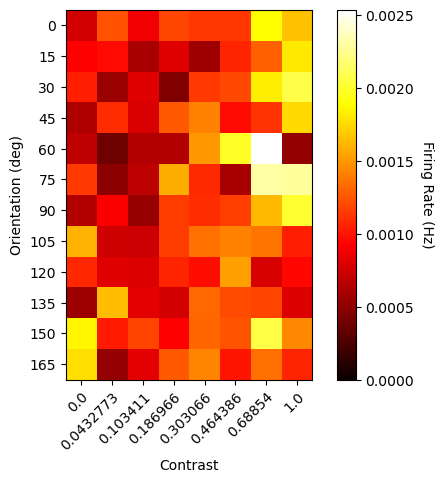

In [29]:
M, Sd = oc_matrix(9, spatial_frequencies[0])
oc_heatmap(M)
oc_heatmap(Sd)
M, Sd = oc_matrix(2, spatial_frequencies[4])
oc_heatmap(M)

In [75]:
def first_pc(M):
    U, S, Vh = np.linalg.svd(M, full_matrices=False)
    #print(U.shape)
    
    pc1mag = S[0] / np.linalg.norm(S)
    
    
    pc1 = S[0] * np.outer(U[:, 0], Vh[0, :])
    
    
    #print(pc1.shape)
    
    #print(S, pc1mag)
    
    return pc1, M - pc1, pc1mag

In [112]:
def structure(M, Sd):
    Ma = np.absolute(M)
    #X = np.maximum(0, Ma - Sd)
    #return np.mean(X) / np.mean(Ma)
    return 1 - np.mean(np.exp(-Ma/Sd))

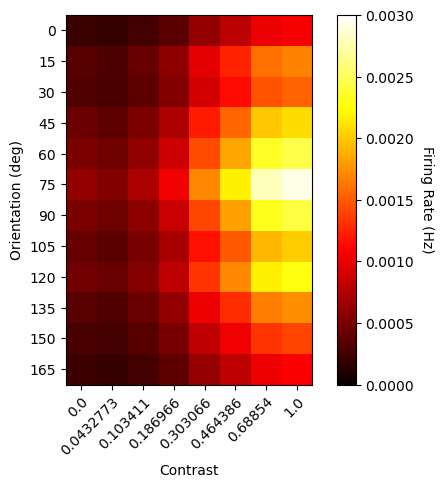

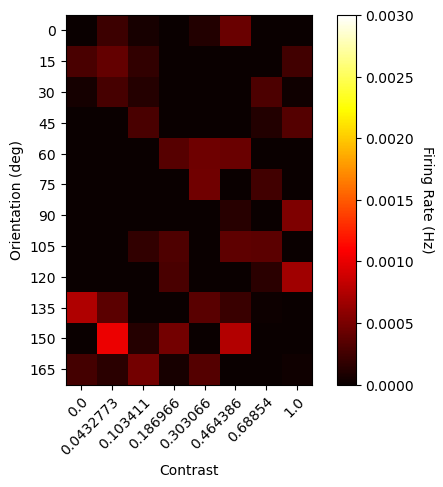

0.23080070060549962


In [113]:
M, Sd = oc_matrix(9, spatial_frequencies[0])
pc1, res, mag = first_pc(M)
oc_heatmap(pc1, .003)
oc_heatmap(res, .003)
print(structure(res, Sd))

In [114]:
pc1_list = []
struct_list = []

for u in units:
    for spf in spatial_frequencies:
        M, Sd = oc_matrix(u, spf)
        pc1, res, mag = first_pc(M)

        pc1_list.append(mag)
        struct_list.append(structure(res, Sd))
        #print(structure(res, Sd))

/var/folders/n5/hb4kjbnx7ps8vgjsds15rzvh0000gn/T/ipykernel_2471/2655086619.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - np.mean(np.exp(-Ma/Sd))
/var/folders/n5/hb4kjbnx7ps8vgjsds15rzvh0000gn/T/ipykernel_2471/2655086619.py:5: RuntimeWarning: invalid value encountered in true_divide
  return 1 - np.mean(np.exp(-Ma/Sd))


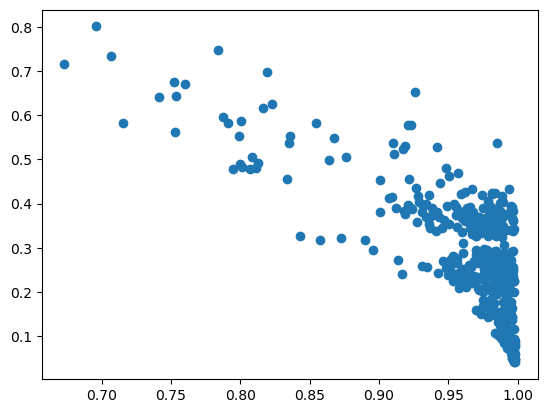

In [115]:
plt.scatter(pc1_list, struct_list)
plt.show()